# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

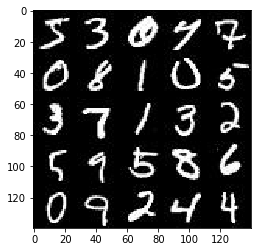

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

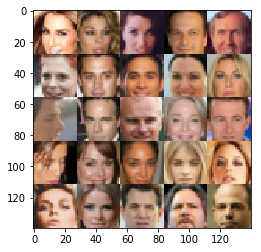

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\Pitto\Anaconda3\envs\tensorflow1_1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        strt = 7
        st_filt = 512 
        x1 = tf.layers.dense(z, strt*strt*st_filt)
        x1 = tf.reshape(x1, (-1, strt, strt, st_filt))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_out_real,d_logits_real = discriminator(input_real, False)
    g_model = generator(input_z, out_channel_dim)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    b,x,y,c=data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                ii = ii+1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                if ii % 10 == 0 : 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 1.5057
Epoch 1/2... Discriminator Loss: 1.7466... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.8753... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.5969... Generator Loss: 1.5583
Epoch 1/2... Discriminator Loss: 1.6550... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.9824... Generator Loss: 0.2665
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.7124
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 1.0287


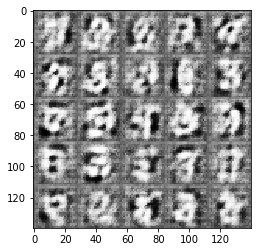

Epoch 1/2... Discriminator Loss: 1.7179... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 1.7682
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 1.2414
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 1.3186


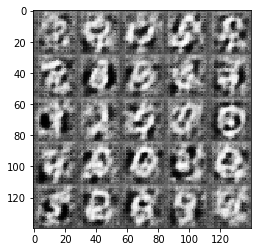

Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 1.5017
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 1.5800
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.7918


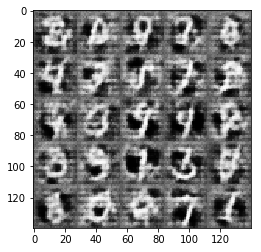

Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 1.3564
Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.6115


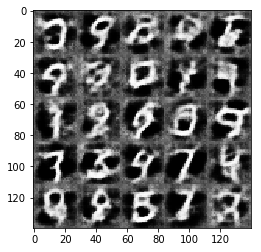

Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.0579
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 1.2799
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 1.0279


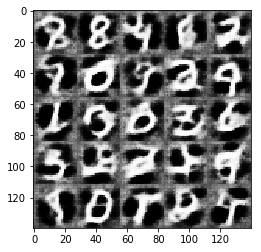

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 1.2745
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 1.0541
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 1.3777


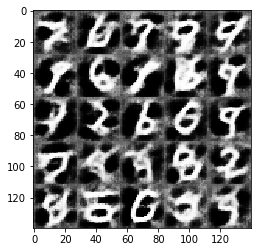

Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.7361... Generator Loss: 0.3390
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 1.6161


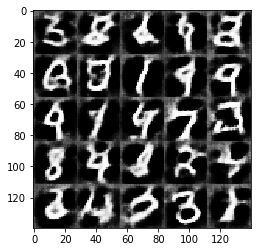

Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 2.2531
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.0715
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.2989
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 2.2254
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 0.8160


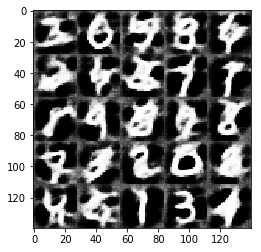

Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 1.7212... Generator Loss: 0.3450
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.4846
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.5462
Epoch 1/2... Discriminator Loss: 2.3273... Generator Loss: 0.2272
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 1.3233
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 1.4415
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.8842


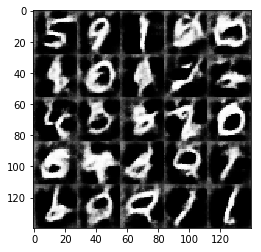

Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.9942... Generator Loss: 0.2528
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.1771
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 1.7358
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 0.9921
Epoch 2/2... Discriminator Loss: 1.6347... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.5564... Generator Loss: 0.4193


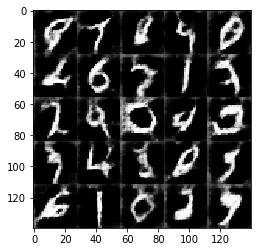

Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.3651
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 1.1795
Epoch 2/2... Discriminator Loss: 1.0073... Generator Loss: 0.9501
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 2.0530
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 1.6643


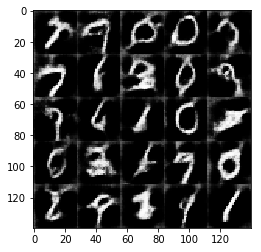

Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 1.0241
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 2.9758... Generator Loss: 0.1430
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.7389


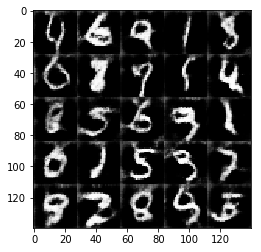

Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 1.9871... Generator Loss: 0.2713
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 1.8640
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.1372
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.4708
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.0153


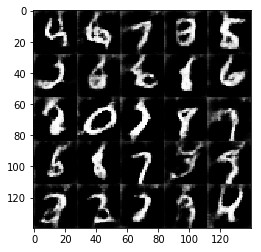

Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 2.1886
Epoch 2/2... Discriminator Loss: 1.1203... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.1968
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 2.2756
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 1.1727
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.9027


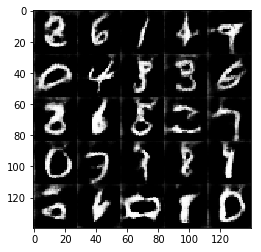

Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.7995
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.5134
Epoch 2/2... Discriminator Loss: 1.5919... Generator Loss: 2.1532
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 0.9361... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 1.1246


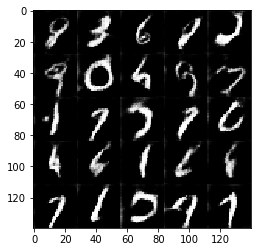

Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 1.2838
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 1.9121
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 1.0080
Epoch 2/2... Discriminator Loss: 1.8582... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.6067
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.6643


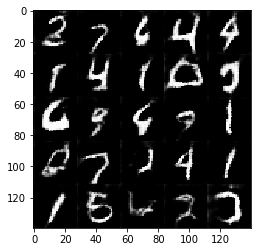

Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 1.0720
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.1787
Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.2471
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.6034
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.8496


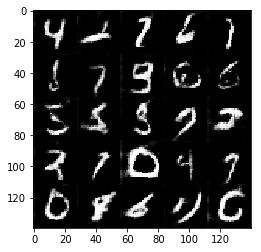

Epoch 2/2... Discriminator Loss: 0.9594... Generator Loss: 1.1061
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.4500
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 2.3554
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.8808
Epoch 2/2... Discriminator Loss: 1.8315... Generator Loss: 0.3759
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.1952
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 1.0469
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 1.0267
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.9101


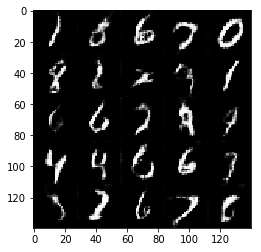

Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 1.1016... Generator Loss: 0.9410


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 2.0407
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 3.2950
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 2.3495
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.5611
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 2.3949
Epoch 1/1... Discriminator Loss: 1.8496... Generator Loss: 7.7842
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 3.5749


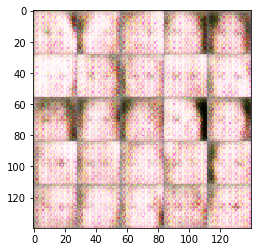

Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 4.6578
Epoch 1/1... Discriminator Loss: 2.3600... Generator Loss: 0.2774
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.8165... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 1.7222
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 0.4690


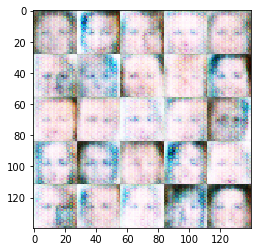

Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 5.2587
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.3012
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 2.2793
Epoch 1/1... Discriminator Loss: 2.3243... Generator Loss: 0.1919
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 4.2090
Epoch 1/1... Discriminator Loss: 2.2889... Generator Loss: 3.7000


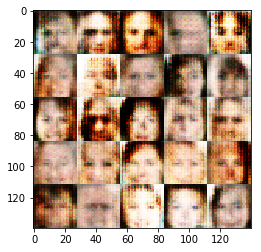

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 4.4486
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 3.1719
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 5.2625
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.1935
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.9752


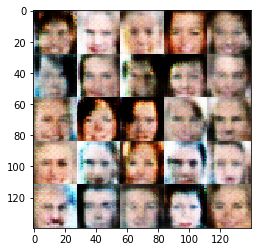

Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.4774
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.7630
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 3.9242
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 1.8136
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 2.9241
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 3.2762


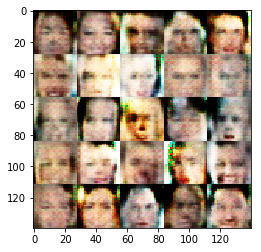

Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 2.6320
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.4678
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.0376
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 4.9370
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 1.8217
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.8589
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 4.6269
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 2.4348
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 5.2271


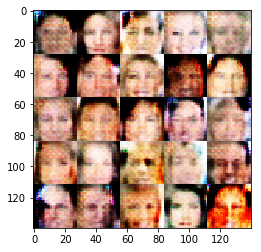

Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 3.6430
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 4.1658
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 4.1567
Epoch 1/1... Discriminator Loss: 1.7689... Generator Loss: 4.8049
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 4.3327
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.3210
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 4.6205
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.4632


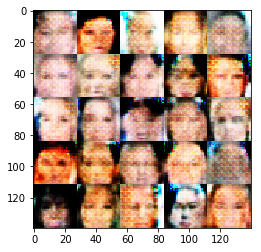

Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 4.3007
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 4.6799
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 4.1868
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 4.3371
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.7777
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 2.9664
Epoch 1/1... Discriminator Loss: 2.4963... Generator Loss: 2.9202
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 4.1733
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.8773


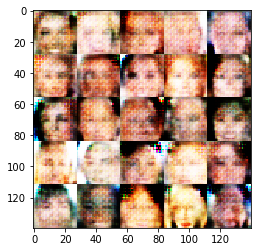

Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.9765
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 2.7576
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 2.9375
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 2.5547
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 1.9994
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.2090


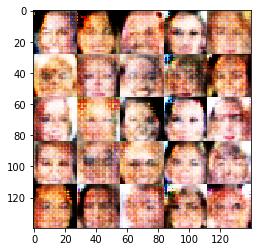

Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 3.5485
Epoch 1/1... Discriminator Loss: 1.9921... Generator Loss: 4.2352
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 2.9005
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 3.1222
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 4.2187
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.1467
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 3.1502
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.9287
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 3.9764


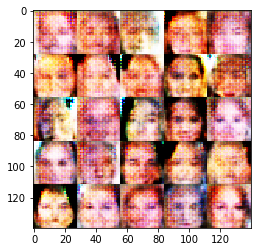

Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.9457
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.4332
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 2.0481
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.0133
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.6468
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 3.8858
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 2.5936
Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 2.3353


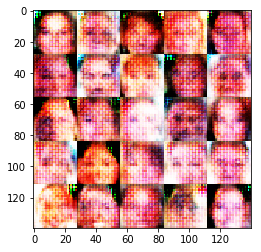

Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.6211
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 2.9376
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 3.4806
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.6374
Epoch 1/1... Discriminator Loss: 2.0599... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 2.6130
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 2.6623
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 3.1937
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 2.1184


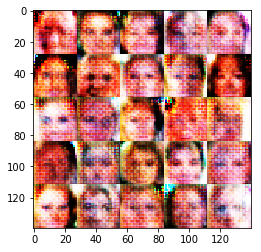

Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 3.2759
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 3.0640
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 2.1259
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.9881
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 2.0070
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.9350
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.9095


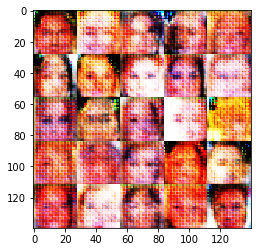

Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 3.6711
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 4.0231
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.7892
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 3.1132
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.2444
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.9787
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 1.5560


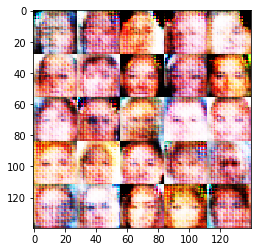

Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.6063
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.7442
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 1.7662
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 1.9363... Generator Loss: 3.3904
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.8362


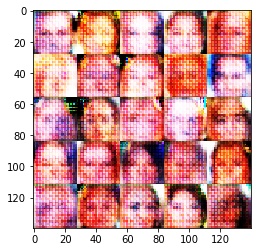

Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.6626
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.7553
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 2.5815
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.7698
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.6549
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 3.8893
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 3.1610
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.4206


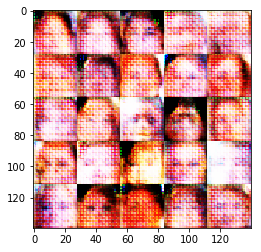

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.7816
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 2.4842
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 3.2475
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 2.0475
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 3.6332
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.5430
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.1640
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.7157


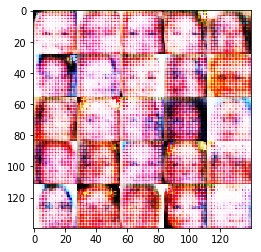

Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 3.4146
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 3.2874
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 1.7418... Generator Loss: 3.1352
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 2.5730
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 2.8092


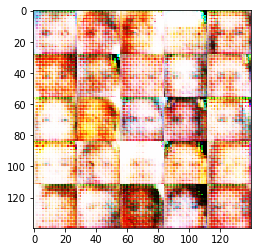

Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.5119
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 3.2514
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 2.8263
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.4379
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 4.4262
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 2.9886
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 2.7160
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.6866
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.9600


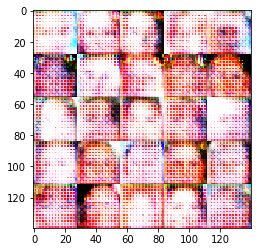

Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.6642
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 3.4715
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 2.6633
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.7271
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.3035


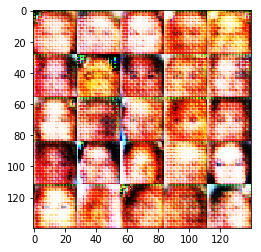

Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 1.9347... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.8818
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.4505
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.4445
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 3.0643
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.5578


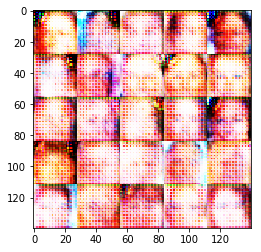

Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.5148
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.8380
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 2.7051
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.6297


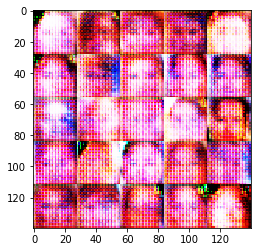

Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.9833
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 3.7752
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.8547
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.0224
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 2.2798


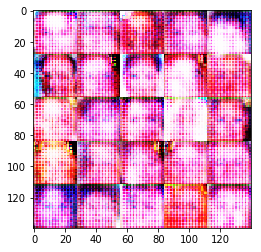

Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.9732
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.0453
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 2.6040
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 2.0819
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.2485
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 2.3697
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.3277


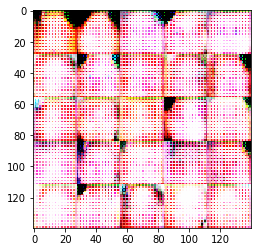

Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.7732
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 2.7725
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 2.2981
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 2.1949
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.8399
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 2.7201
Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 2.8637
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.3019


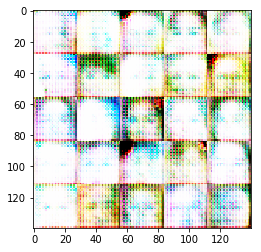

Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 2.2914
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 3.6142
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 3.7448
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.7157
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 2.6806
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.9102


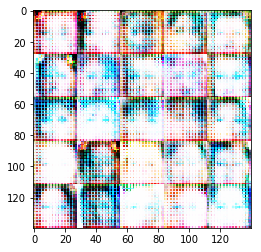

Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 1.8757
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.3552
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.7912
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 2.8302
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 3.2961
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 2.9454
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.3411


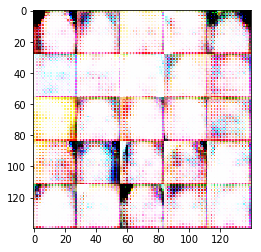

Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 5.5507
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 3.0421
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.7932
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.2056
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 3.8419
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 2.7189
Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 0.4222


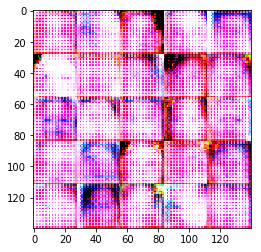

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.5685
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 3.1529
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 3.7710
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 3.4183
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 2.3506


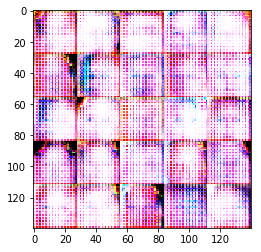

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 2.0861
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.7590
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 4.3760
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 2.1477
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.9797
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 2.4131


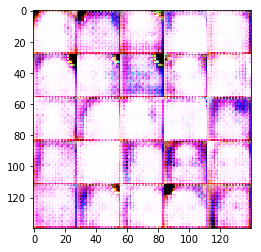

Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.4195
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 2.9214
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.9012
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 2.1419
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.6360


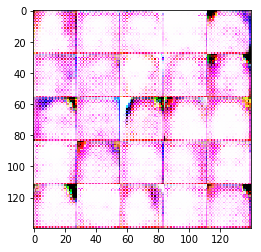

Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 2.5367
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 4.3915
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 3.4044
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 4.1431
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 4.2554


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.